# On importe les librairies requises 

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os
import time
from sklearn.cluster import KMeans
from skimage.color import rgb2lab, lab2rgb


# On charge les images correspondantes au motifs a rechercher

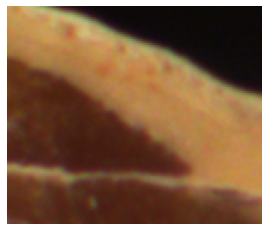

(100, 117, 3)


In [14]:
template_nucleus = cv2.imread('./Motifs/motif_nucleus_1.png')

if template_nucleus is None:
    print("Error: Could not read the image.")
else:
    # Continue with displaying the image.
    cv2.imshow('template_nucleus', template_nucleus)
    plt.imshow(cv2.cvtColor(template_nucleus, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    print(template_nucleus.shape)


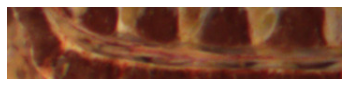

(100, 117, 3)


In [15]:
template_cotes = cv2.imread('./Motifs/motif_bas_1.png')

if template_cotes is None:
    print("Error: Could not read the image.")
else:
    # Continue with displaying the image.
    cv2.imshow('template_cotes', template_cotes)
    plt.imshow(cv2.cvtColor(template_cotes, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    print(template_nucleus.shape)


# On réalise les fonctions qui seront utilisées dans le script principal

In [3]:
def ajout_box(image):
    # On cherche le muscle nucleus
    result = cv2.matchTemplate(image, template_nucleus, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    #print( cv2.minMaxLoc(result))
    seuil = 0.6
    if max_val > seuil:
        #print("Le motif a été détecté")
        h, w, _ = template_nucleus.shape
        top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
    #else : 
        #print("Motif non reconnu")
        
    # On recercher les cotes    
    result = cv2.matchTemplate(image, template_cotes, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    #print( cv2.minMaxLoc(result))
    seuil = 0.4
    if max_val > seuil:
        #print("Le motif a été détecté")
        h, w, _ = template_cotes.shape
        top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
   # else : 
        #print(f"Motif non reconnu : {max_val} < {seuil}")
    
    #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    #plt.axis('off')  # Pour masquer les axes
    #plt.show()
    return image
        

In [53]:
def traitement_kmean(image_init,k): 
    
    #image = rgb2lab(image_init)
    #image = cv2.cvtColor(image_init, cv2.COLOR_BGR2YUV)
    image = image_init
    pixel_matrix = np.array(image)
    
    # Redimensionner la matrice de pixels en une liste de pixels
    pixels = pixel_matrix.reshape(-1, 3)
    # Appliquer K-Means pour réduire les couleurs
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(pixels)
    labels = kmeans.predict(pixels)
    cluster_centers = kmeans.cluster_centers_

    # Remplacer les couleurs des pixels par les couleurs moyennes des catégories
    pixels_reduced = cluster_centers[labels].reshape(pixel_matrix.shape)

    # Créer une nouvelle image à partir des pixels réduits
    image_reduced = Image.fromarray(pixels_reduced.astype('uint8')) 
    return image_reduced

In [56]:
def traitement_kmean_YUV(image_init,k): 
    
    image = rgb2lab(image_init)
    image = cv2.cvtColor(image_init, cv2.COLOR_BGR2YUV)
    
    pixel_matrix = np.array(image)
    
    # Redimensionner la matrice de pixels en une liste de pixels
    pixels = pixel_matrix.reshape(-1, 3)
    # Appliquer K-Means pour réduire les couleurs
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(pixels)
    labels = kmeans.predict(pixels)
    cluster_centers = kmeans.cluster_centers_

    # Remplacer les couleurs des pixels par les couleurs moyennes des catégories
    pixels_reduced = cluster_centers[labels].reshape(pixel_matrix.shape)

    # Créer une nouvelle image à partir des pixels réduits
    image_reduced = Image.fromarray(pixels_reduced.astype('uint8')) 
    return image_reduced

In [57]:
def traitement_kmean_lab(image_init, k):
    # Conversion de l'image BGR en RGB
    image_rgb = cv2.cvtColor(image_init, cv2.COLOR_BGR2RGB)
    # Conversion de l'image RGB en LAB
    image_lab = rgb2lab(image_rgb)
    # Redimensionner la matrice de pixels en une liste de pixels
    pixels = image_lab.reshape(-1, 3)
    # Appliquer K-Means pour réduire les couleurs
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(pixels)
    labels = kmeans.predict(pixels)
    cluster_centers = kmeans.cluster_centers_
    # Remplacer les couleurs des pixels par les couleurs moyennes des catégories
    pixels_reduced = cluster_centers[labels].reshape(image_lab.shape)
    # Convertir l'image LAB réduite en RGB
    image_reduced_rgb = lab2rgb(pixels_reduced)
    # Assurer que les valeurs des pixels sont dans la plage [0, 1]
    image_reduced_rgb = np.clip(image_reduced_rgb, 0, 1)
    # Convertir l'image réduite en RGB en entiers dans la plage [0, 255]
    image_reduced_rgb = (image_reduced_rgb * 255).astype('uint8')
    # Créer une nouvelle image à partir des pixels réduits en RGB
    image_reduced = Image.fromarray(image_reduced_rgb)
    return image_reduced

# Traitement du dossier

## Ajout des zones

In [30]:
dossier_source = "./Images_originales"
chemin_destination = "./Images_finales"
nb_images = 0 
temps_debut = time.time()

for nom_fichier in os.listdir(dossier_source):
    chemin_image = os.path.join(dossier_source, nom_fichier)
    nb_images += 1
    # Vérifier si le fichier est une image (extension png, jpg, etc.)
    if os.path.isfile(chemin_image) and nom_fichier.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Appeler la fonction de traitement pour chaque image
        img = cv2.imread(chemin_image)
        image_traitee = ajout_box(img)
        
        
        nom_fichier_destination = os.path.join(chemin_destination, nom_fichier)
        Image.fromarray(image_traitee).save(nom_fichier_destination)

        
duree = time.time() - temps_debut
print(f"Le programme a mis {duree} secondes à s'exécuter pour {nb_images} images.")


Le programme a mis 29.81593155860901 secondes à s'exécuter pour 950 images.


## KMEAN

In [55]:
# Images_originales_finales
# Images_originales_réduit
# Images_originales
dossier_source = "./Images_originales"
chemin_destination = "./Images_kmean_30"
nb_images = 0 
temps_debut = time.time()

for nom_fichier in os.listdir(dossier_source):
    chemin_image = os.path.join(dossier_source, nom_fichier)
    nb_images += 1
    # Vérifier si le fichier est une image (extension png, jpg, etc.)
    if os.path.isfile(chemin_image) and nom_fichier.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Appeler la fonction de traitement pour chaque image
        #print(nom_fichier)
        img = cv2.imread(chemin_image)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        
        image_traitee = traitement_kmean(img,3)  
        nom_fichier_destination = os.path.join(chemin_destination, nom_fichier)
        
        image_traitee_rgb = cv2.cvtColor(np.array(image_traitee), cv2.COLOR_BGR2RGB)
        Image.fromarray(image_traitee_rgb).save(nom_fichier_destination)

        
duree = time.time() - temps_debut
print(f"Le programme a mis {duree} secondes à s'exécuter pour {nb_images} images.")


Le programme a mis 861.4518733024597 secondes à s'exécuter pour 950 images.


## LAB

In [58]:
# Images_originales_finales
# Images_originales_réduit
# Images_originales
dossier_source = "./Images_originales"
chemin_destination = "./Images_kmean_LAB"
nb_images = 0 
temps_debut = time.time()

for nom_fichier in os.listdir(dossier_source):
    chemin_image = os.path.join(dossier_source, nom_fichier)
    nb_images += 1
    # Vérifier si le fichier est une image (extension png, jpg, etc.)
    if os.path.isfile(chemin_image) and nom_fichier.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Appeler la fonction de traitement pour chaque image
        #print(nom_fichier)
        img = cv2.imread(chemin_image)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        
        image_traitee = traitement_kmean_lab(img,3)  
        nom_fichier_destination = os.path.join(chemin_destination, nom_fichier)
        
        image_traitee_rgb = cv2.cvtColor(np.array(image_traitee), cv2.COLOR_BGR2RGB)
        Image.fromarray(image_traitee_rgb).save(nom_fichier_destination)

        
duree = time.time() - temps_debut
print(f"Le programme a mis {duree} secondes à s'exécuter pour {nb_images} images.")


Le programme a mis 897.2709474563599 secondes à s'exécuter pour 950 images.


## YUV

In [ ]:
# Images_originales_finales
# Images_originales_réduit
# Images_originales
dossier_source = "./Images_originales"
chemin_destination = "./Images_kmean_YUV"
nb_images = 0 
temps_debut = time.time()

for nom_fichier in os.listdir(dossier_source):
    chemin_image = os.path.join(dossier_source, nom_fichier)
    nb_images += 1
    # Vérifier si le fichier est une image (extension png, jpg, etc.)
    if os.path.isfile(chemin_image) and nom_fichier.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Appeler la fonction de traitement pour chaque image
        #print(nom_fichier)
        img = cv2.imread(chemin_image)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        
        image_traitee = traitement_kmean_YUV(img,3)  
        nom_fichier_destination = os.path.join(chemin_destination, nom_fichier)
        
        image_traitee_rgb = cv2.cvtColor(np.array(image_traitee), cv2.COLOR_BGR2RGB)
        Image.fromarray(image_traitee_rgb).save(nom_fichier_destination)

        
duree = time.time() - temps_debut
print(f"Le programme a mis {duree} secondes à s'exécuter pour {nb_images} images.")
